In [79]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from lifelines import CoxPHFitter
%config InlineBackend.figure_format='retina'

gender = 'female'

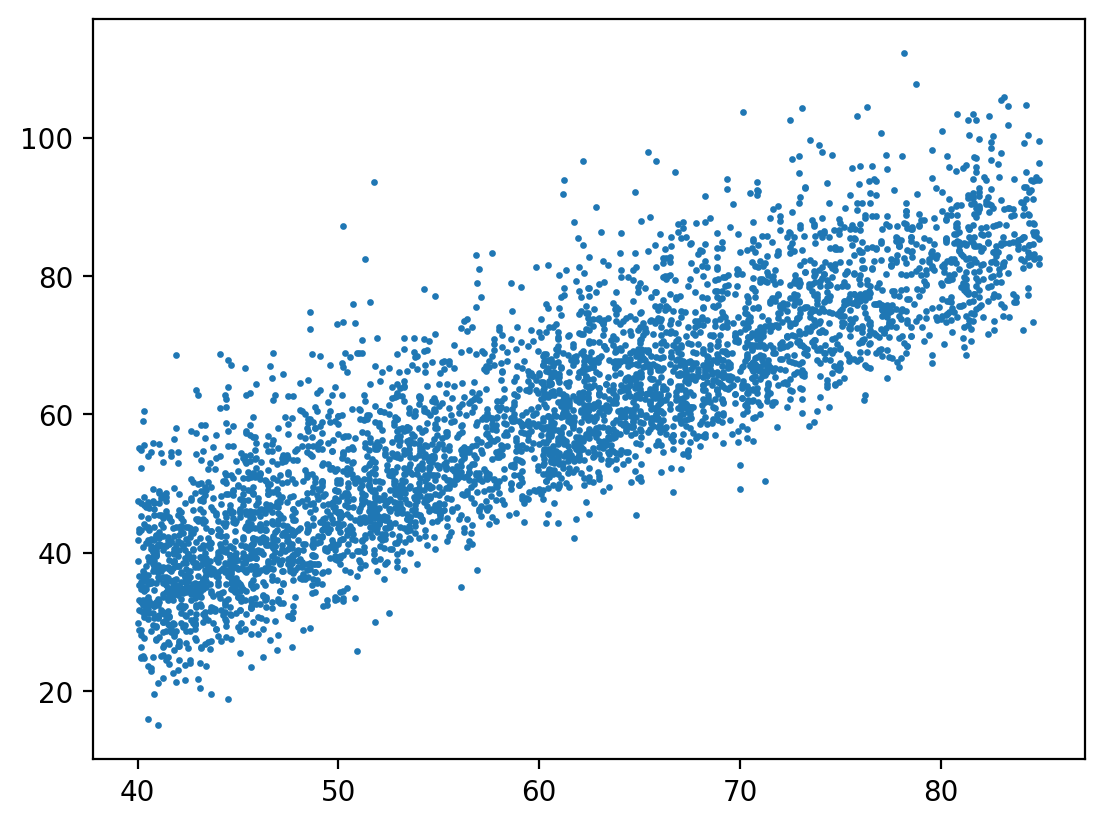

In [80]:
nhanes = pd.read_csv('linAge2_code/mergedDataNHANES9902.csv', index_col=0)
df = pd.read_csv('linAge2_code/linAge2__output.csv')

plt.scatter(df['chronAge'], df['bioAge'], 2)


In [81]:

df_merged = pd.merge(df, nhanes, on='SEQN')

event_col = 'MORTSTAT'
duration_col = 'PERMTH_EXM'

if gender == 'male':
    lin_age_gender = 1
if gender == 'female':
    lin_age_gender = 2

df_merged = df_merged[
    (df_merged['dataset'] == 'test') &
    (df_merged['RIAGENDR'] == lin_age_gender)
]

cph = CoxPHFitter().fit(
    df_merged[['bioAge', event_col, duration_col]].dropna(),
    event_col=event_col,
    duration_col=duration_col
)
cph.print_summary()


<lifelines.CoxPHFitter: fitted with 1143 total observations, 787 right-censored observations>
             duration col = 'PERMTH_EXM'
                event col = 'MORTSTAT'
      baseline estimation = breslow
   number of observations = 1143
number of events observed = 356
   partial log-likelihood = -2145.69
         time fit was run = 2026-01-06 22:07:20 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
bioAge     0.09      1.09      0.00            0.08            0.10                1.09                1.10

           cmp to     z      p  -log2(p)
covariate                               
bioAge       0.00 21.88 <0.005    350.20
---
Concordance = 0.83
Partial AIC = 4293.37
log-likelihood ratio test = 580.36 on 1 df
-log2(p) of ll-ratio test = 423.56

In [82]:
output_dir = f'/Users/jkember/Documents/nia_health/NHANES/biological_age/data/'

data = pd.read_csv(f'{output_dir}/NHANES_data_{gender}.csv')

# Match SEQN with LinAge2 data.
data['SEQN'] = [seqn.replace('C-','') for seqn in data['SEQN_new']]
data['SEQN'] = pd.to_numeric(data['SEQN'], errors='coerce')


# Calculate total biological-age.
mrdt = 7.5
df_cox = pd.DataFrame()
df_cox[duration_col] = data[duration_col]
df_cox[event_col] = data[event_col]

deltas = pd.read_csv(f'{output_dir}/output_{gender}/biomarker_delta_ages.csv')
df_cox['score'] = deltas.mean(axis=1)

cph = CoxPHFitter().fit(df_cox, duration_col, event_col)
HR_per_unit = cph.summary['exp(coef)'].item()
years_per_unit = (np.log(HR_per_unit) / np.log(2)) * mrdt
df_cox['score'] = df_cox['score'] * years_per_unit

data['bio_age'] = data['age'] + df_cox['score']

In [83]:
final_merged = pd.merge(df_merged, data, on='SEQN')
final_merged['PERMTH_EXM'] = final_merged['PERMTH_EXM_x']
final_merged['MORTSTAT'] = final_merged['MORTSTAT_x']


cph = CoxPHFitter().fit(
    final_merged[['bioAge', event_col, duration_col]].dropna(),
    event_col=event_col,
    duration_col=duration_col
)
cph.print_summary()


cph = CoxPHFitter().fit(
    final_merged[['bio_age', event_col, duration_col]].dropna(),
    event_col=event_col,
    duration_col=duration_col
)
cph.print_summary()


<lifelines.CoxPHFitter: fitted with 809 total observations, 609 right-censored observations>
             duration col = 'PERMTH_EXM'
                event col = 'MORTSTAT'
      baseline estimation = breslow
   number of observations = 809
number of events observed = 200
   partial log-likelihood = -1141.95
         time fit was run = 2026-01-06 22:07:20 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
bioAge     0.09      1.09      0.01            0.08            0.10                1.08                1.10

           cmp to     z      p  -log2(p)
covariate                               
bioAge       0.00 16.84 <0.005    209.02
---
Concordance = 0.83
Partial AIC = 2285.91
log-likelihood ratio test = 330.85 on 1 df
-log2(p) of ll-ratio test = 243.17

<lifelines.CoxPHFitter: fitted with 809 total observations, 609 right-censored observations>
             duration col = 'PERMTH_EXM'
                event col = 'MORTSTAT'
      baseline estimation = breslow
   number of observations = 809
number of events observed = 200
   partial log-likelihood = -1178.43
         time fit was run = 2026-01-06 22:07:20 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
bio_age    0.10      1.11      0.01            0.09            0.11                1.09                1.12

           cmp to     z      p  -log2(p)
covariate                               
bio_age      0.00 14.70 <0.005    160.03
---
Concordance = 0.79
Partial AIC = 2358.86
log-likelihood ratio test = 257.89 on 1 df
-log2(p) of ll-ratio test = 190.36

In [84]:
from lifelines import KaplanMeierFitter

def get_survival_diff(df_marker, marker, n_years=20):

    # Split df_marker based on low and high interquartile ranges.
    low_IQR = df_marker[marker].quantile(0.25)
    high_IQR = df_marker[marker].quantile(0.75)

    df_marker_low = df_marker[df_marker[marker] <= low_IQR]
    df_marker_high = df_marker[df_marker[marker] >= high_IQR]

    # Calculate Kaplan-Meier curves for bottom and top quartiles.
    kmf_low = KaplanMeierFitter().fit(df_marker_low['PERMTH_EXM'], event_observed=df_marker_low['MORTSTAT'])
    kmf_high = KaplanMeierFitter().fit(df_marker_high['PERMTH_EXM'], event_observed=df_marker_high['MORTSTAT'])

    # Calculate % of subjects still alive after N years. 
    n_months = n_years*12
    S_low = kmf_low.predict(n_months)
    S_high = kmf_high.predict(n_months)

    # Take the difference, convert to percentage.
    survival_diff = np.abs(S_low - S_high)*100

    return survival_diff


results = {}

for n_years in [15,20,25]:

    survival_diffs = {}
    for marker in ['bio_age','bioAge']:

        df_marker = final_merged[['PERMTH_EXM','MORTSTAT',marker]]
        df_marker = df_marker.dropna()

        survival_diffs[marker] = get_survival_diff(df_marker, marker, n_years=n_years)

    results[n_years] = survival_diffs

results

{15: {'bio_age': np.float64(42.8571428571429),
  'bioAge': np.float64(50.24630541871922)},
 20: {'bio_age': np.float64(54.563460934454866),
  'bioAge': np.float64(63.03775362532551)},
 25: {'bio_age': np.float64(54.563460934454866),
  'bioAge': np.float64(63.03775362532551)}}

Text(0, 0.5, 'LinAge2')

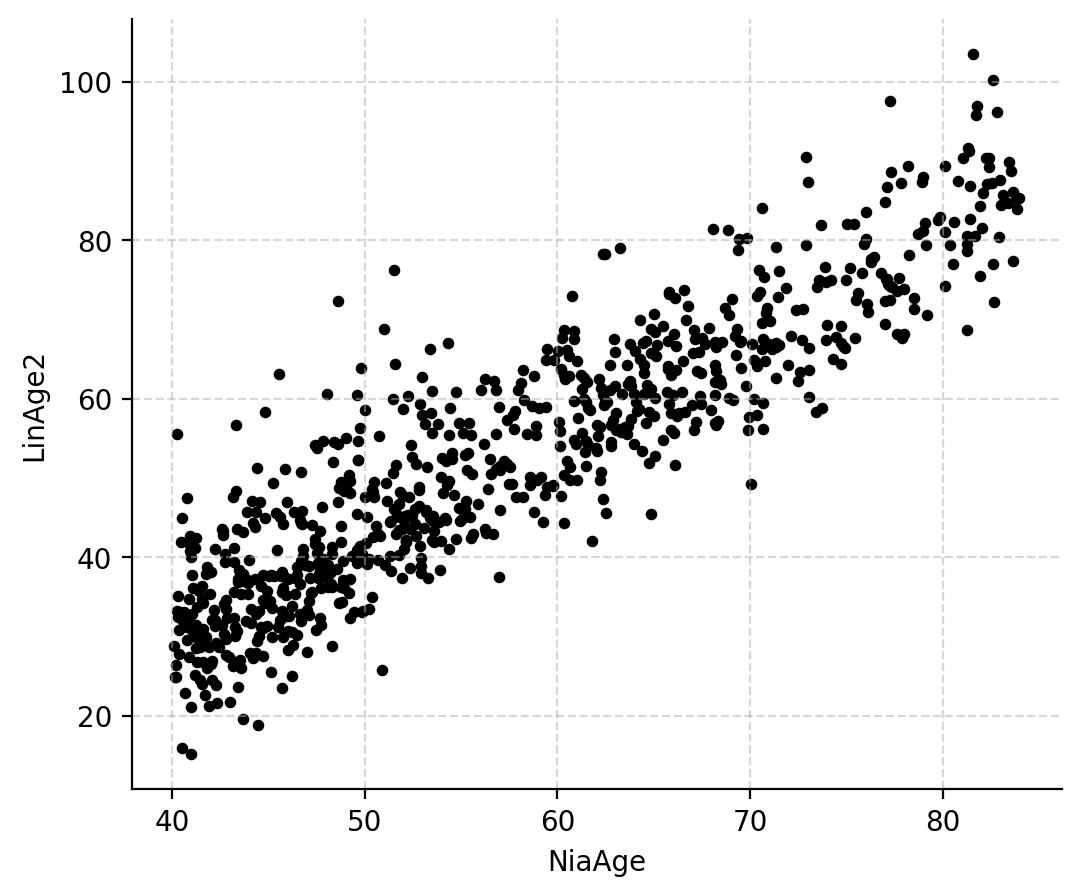

In [85]:
fig, ax = plt.subplots(figsize=(6, 5))
plt.scatter(final_merged['bio_age'], final_merged['bioAge'], s=10, color='k')
sns.despine()
ax.grid(linestyle='--', alpha=.5)
ax.set_xlabel('NiaAge')
ax.set_ylabel('LinAge2')

In [86]:
from lifelines.statistics import logrank_test



lin_age_quartile = final_merged[final_merged['bioAge'] > final_merged['bioAge'].quantile(.75)]
nia_age_quartile = final_merged[final_merged['bio_age'] > final_merged['bio_age'].quantile(.75)]


logrank_test(
    nia_age_quartile['PERMTH_EXM'],
    lin_age_quartile['PERMTH_EXM'],
    event_observed_A=nia_age_quartile['MORTSTAT'],
    event_observed_B=lin_age_quartile['MORTSTAT'],
)



<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           1.64 0.20      2.32

In [93]:
from sklearn.metrics import roc_auc_score

n_years = 20

auc_nia = roc_auc_score(
    final_merged[final_merged['PERMTH_EXM'] > n_years]['MORTSTAT'],
    final_merged[final_merged['PERMTH_EXM'] > n_years]['bio_age']
)

auc_lin = roc_auc_score(
    final_merged[final_merged['PERMTH_EXM'] > n_years]['MORTSTAT'],
    final_merged[final_merged['PERMTH_EXM'] > n_years]['bioAge']
)

auc_nia, auc_lin


(0.829025104531681, 0.8602237909027812)